# Custom Training EDA
This notebook houses EDA and model evaluation regarding YOLOv5's custom training functionality. We are using images from CSU Long Beach wildlife research to find the number of images that are needed for reliable few-shot training with YOLOv5, as well as develop analytics visualizations that users can gain easy insights from.

**Note:** This notebook requires the user to have a local clone of the [YOLOv5](https://github.com/ultralytics/yolov5) Github repository. The user should first set up the dependencies for the YOLOv5 model before running this notebook. This notebook expects to be located within the root `yolov5/` directory of the YOLOv5 repository.

## Imports

In [1]:
# ensuring that module requirements are installed
!pip install -qr requirements.txt
!pip install -q tensorboard
!pip install -q protobuf
!pip install -q roboflow

In [1]:
import torch
import glob
import os
import shutil

/home/lana-e/miniconda3/envs/capstone/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5m')

Using cache found in /home/lana-e/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-16 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 


In [2]:
print(torch.__version__)

1.13.0+cu117


In [3]:
# downloading data from RoboFlow
from roboflow import Roboflow
rf = Roboflow(api_key="qkPPm7bGHVebQnshSaDV")
project = rf.workspace("farmlife").project("animl-sample-dataset")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to AniML-Sample-Dataset-1 in yolov5pytorch:: 100%|███| 132/132 [00:00<00:00, 8560.33it/s]


## Custom Training With RoboFlow Annotated Images
This section requires that a [RoboFlow](https://roboflow.com/) project exists with annotations for various classes within the image set.

In [4]:
# defining parameters for YOLOv5 run command (defining here so they can be easily edited)
img_size = 640 # image size, default 640
batch_size = 16 # batch size, default 16
epochs = 150 # number of epochs, default 150

In [17]:
# custom training command
# ended up moving this to a Google Colab notebook with GPU acceleration
# !python train.py --img $img_size --batch $batch_size --epochs $epochs --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

In [51]:
%%time
# running detection on sample dataset
# /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/
!python detect.py --weights best1.pt --img $img_size --conf 0.2 --source /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/ --save-txt --save-conf

detect: weights=['best1.pt'], source=/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-205-geef9057 Python-3.10.6 torch-1.12.1+cu102 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/174 /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/09080001.JPG: 480x640 (no detections), 43.8ms
image 2/174 /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/09080002.JPG: 480x640 (no detections), 42.8ms
image 3/174 /home/lana-e/MIDS/W210/MIDS_W

In [17]:
%%time
# running detection on sample dataset
data_dir = f"{dataset.location}/data.yaml"
!python val.py --weights bestm175.pt --img $img_size --conf 0.2 --data $data_dir --batch-size $batch_size --save-txt --save-conf --save-json

val: data=/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/backend/vision_model/yolov5/AniML-Sample-Dataset-1/data.yaml, weights=['bestm175.pt'], batch_size=16, imgsz=640, conf_thres=0.2, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.2 > 0.001 produces invalid results
YOLOv5 🚀 v6.2-246-ge40662f Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 
Model summary: 212 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning '/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/backend/
                 Class     Images  Instances          P          R      mAP50   
                   all         40         13      0.476      0.533      0.467      0.343
                Coyote         40          2    

## Evaluating Custom Trained Model
This section evaluates the performance of various YOLOv5 models, trained with various numbers of training images for few-shot learning.

In [2]:
def parse_label_txt(label_filename):
    '''
    Function to parse YOLOv5 output label .txt files.
    Input: Filename for label .txt file
    Outputs:
    - pred_classes: List of ints. Predicted classes within image.
    - bboxes: List of lists. Each sub-list defines a bounding box for an object within an image.
    - confs: List of floats. Confidence interval for each classification within an image.
    Each list from the output is the same length, which is the number of detected objects within the image above the confidence threshold.
    '''
    
    import ast
    
    # reading labels txt file to parse labels
    with open(label_filename, "r") as labels:
        # initializing lists to store parsed values
        pred_classes = []
        bboxes = []
        confs = []
        # looping through each line (one line = one label)
        for label in labels:
            # parsing line
            pred_class, bbox1, bbox2, bbox3, bbox4, conf = label.split()
            # adding label info to stored lists
            pred_classes.append(ast.literal_eval(pred_class))
            bboxes.append([float(bbox1), float(bbox2), float(bbox3), float(bbox4)])
            confs.append(float(conf))
    
    return pred_classes, bboxes, confs

In [28]:
# hand-labeling images
empty = ["09080002", "09080003", "09080018", "09090020", "09090021", "09090023", "09090024", "09110029", "09110030", "09110032", "09110033", "09120036",
         "09140038", "09140039", "09150041", "09150042", "09150044", "09150045", "09150047", "09150048", "09150050", "09150051", "09150053", "09150054",
         "09160056", "09160057", "09160058", "09160059", "09160060", "09160061", "09160062", "09160063", "09170064", "09170065", "09170066", "09180071",
         "09180072", "09180074", "09180075", "09180076", "09180077", "09180078", "09180080", "09180081", "09200082", "09200083", "09200084", "09200089",
         "09200090", "09200092", "09200093", "09200096", "09210097", "09210098", "09210099", "09210101", "09210102", "09210103", "09210104", "09210105",
         "09220108", "09220109", "09220110", "09220111", "09220116", "09220117", "09230118", "09230119", "09230120", "09230122", "09230123", "09240125",
         "09240126", "09240132", "09240134", "09240135", "09270144", "09270146", "09270147", "09290148", "09290149", "09290150", "09290153", "09290155",
         "09290156", "09290158", "09290159", "10020177", "10020179", "10020180", "10020190", "10020191", "10020192", "10020193"]
person = ["09080001", "09080004", "09080005", "09080006", "09080007", "09080008", "09080009", "09080010", "09080011", "09080012", "09080013", "09080014",
          "09080015", "09290154", "09290157", "10020178", "10020181", "10020182", "10020183", "10020184", "10020185", "10020186", "10020187", "10020188",
          "10020189"]
vehicle = ["09080016", "09080017", "09240127", "09240128", "09240129", "09240130", "09240131", "09250136", "09250137", "09250138", "09270142", "09270143",
           "09290151", "09290152", "09300160", "09300161", "09300162", "09300163", "09300164", "09300165", "09300166", "09300167", "09300168", "09300169",
           "09300170", "09300171", "10010172", "10010173", "10010174", "10020175", "10020176"]
animal = ["09090019", "09090022", "09110025", "09110026", "09110027", "09110028", "09110031", "09120034", "09120035", "09140037", "09150040", "09150043",
          "09150046", "09150049", "09150052", "09160055", "09170067", "09170068", "09170069", "09180070", "09180073", "09180079", "09200085", "09200086",
          "09200087", "09200088", "09200091", "09200094", "09200095", "09210100", "09220106", "09220107", "09220112", "09220113", "09220114", "09220115",
          "09230121", "09240124", "09240133", "09260139", "09260140", "09260141", "09270145"]

# separating just foxes, grabbing 20 fox images for held-out training set
fox = ["09090019", "09110025", "09110026", "09110027", "09110028", "09110031", "09120034", "09120035", "09140037", "09150046",
       "09150049", "09150052", "09160055", "09170067", "09170068", "09170069", "09180079", "09200085", "09200086", "09200087",
       "09200088", "09200091", "09220106", "09220107", "09220112", "09220113", "09220114", "09220115", "09260139", "09260140",
       "09260141"]
training_20 = ["09090019", "09110025", "09110026", "09110027", "09110028", "09110031", "09120034", "09140037", "09150046", "09150052",
               "09160055", "09170068", "09200085", "09200088", "09200091", "09220107", "09220112", "09220113", "09260139", "09260141"]

all_labels = empty + person + vehicle + animal
objects = person + vehicle + animal

# separating fox from non-fox animals for testing
non_fox = animal.copy()
for img in fox:
    non_fox.remove(img)

# taking training set out of evaluation set
train_set = [os.path.basename(img)[:-4] for img in glob.glob(f"../../../data/train_set/*.JPG")]
print(len(animal))
print(len(fox))
for img in train_set:
    animal.remove(img)
    fox.remove(img)
print(len(animal))
print(len(fox))

43
31
23
11


49 images with detected objects


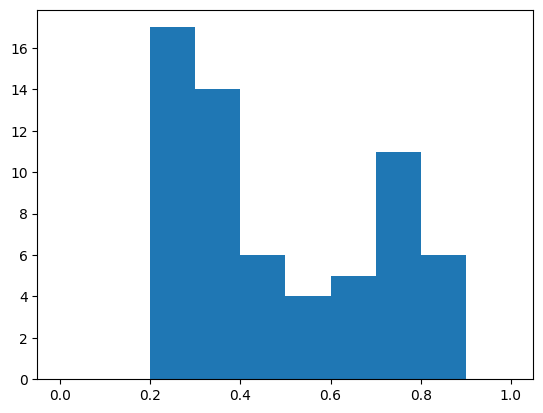

In [29]:
# histogram of confidence levels across all images in dataset
exp_num = "37"
labels_dir = f"runs/detect/exp{exp_num}/labels/*"
label_files = glob.glob(labels_dir)
print(len(label_files), "images with detected objects")

# collecting confidence levels for all classifications in every file
pred_classes = []
bboxes = []
confs = []
for label_file in label_files:
    pred_classes_i, bboxes_i, confs_i = parse_label_txt(label_file)
    pred_classes.extend(pred_classes_i)
    bboxes.extend(bboxes_i)
    confs.extend(confs_i)

# plotting histogram of confidence levels
import matplotlib.pyplot as plt
plt.hist(confs, range=(0, 1), bins=10)
plt.show()

In [31]:
# cleaning up paths to only include filename (without extensions)
pred_objects = [os.path.basename(filename)[:8] for filename in label_files]

# creating confusion matrix
true_pos = []
true_neg = []
false_pos = []
false_neg = []

# looping through true triggers to find true positives and false negatives
# for img_name in objects:
for img_name in fox:
    # if image name is in pred_objects, then it is a true positive
    if img_name in pred_objects:
        true_pos.append(img_name)
    # if image name is not in pred_objects, then it is a false negative
    else:
        false_neg.append(img_name)
    
# looping through false triggers to find true negatives and false positives
# for img_name in empty+person+vehicle:
for img_name in empty+person+non_fox:
    # if image name is not in pred_objects, then it is a true negative
    if img_name not in pred_objects:
        true_neg.append(img_name)
    # if image name is in pred_objects, then it is a false positive
    else:
        false_pos.append(img_name)

# printing counts of confusion matrix
print(len(true_pos), "true positives")
print(len(true_neg), "true negatives")
print(len(false_pos), "false positives")
print(len(false_neg), "false negatives")

# calculating precision and recall
precision = len(true_pos) / (len(true_pos) + len(false_pos))
recall = len(true_pos) / (len(true_pos) + len(false_neg))
f1 = (2 * precision * recall) / (precision + recall)

print(precision, "precision")
print(recall, "recall")
print(f1, "F1")

9 true positives
105 true negatives
26 false positives
2 false negatives
0.2571428571428571 precision
0.8181818181818182 recall
0.39130434782608686 F1


In [38]:
false_neg

['09200086', '09200087']

In [ ]:
# copying images with animals to a separate folder
for img in animal:
    img_path = f"/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/{img}.JPG"
    animals_path = f"/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/just_animals/{img}.JPG"
    shutil.copyfile(img_path, animals_path)

In [ ]:
# moving training images to a separate folder
for img in training_20:
    img_path = f"/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/{img}.JPG"
    train_path = f"/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/train_set/{img}.JPG"
    shutil.move(img_path, train_path)

In [61]:
# noting metrics
n_train = [1, 5, 10, 15, 20]
recall = [0, 0.2727272727272727, 0.5454545454545454, 0.45454545454545453, 0.8181818181818182]
precision = [0, 0.42857142857142855, 0.4, 0.35714285714285715, 0.2571428571428571]
f1 = [0, 0.33333333333333326, 0.4615384615384615, 0.4, 0.39130434782608686]
train_times = [508, 1519, 1409, 1285, 1207]
infer_times = [ 40.3, 34.0, 35.5, 35.8, 36.0]

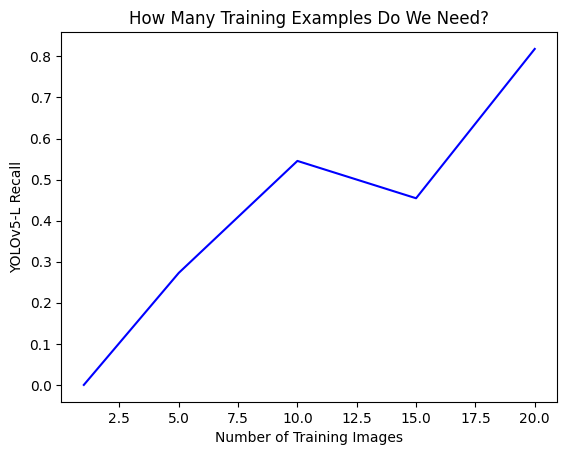

In [53]:
plt.plot(n_train, recall, 'b-')
plt.xlabel("Number of Training Images")
plt.ylabel("YOLOv5-L Recall")
plt.title("How Many Training Examples Do We Need?")
plt.savefig("few_shot_recall.png", bbox_inches="tight")
plt.show()

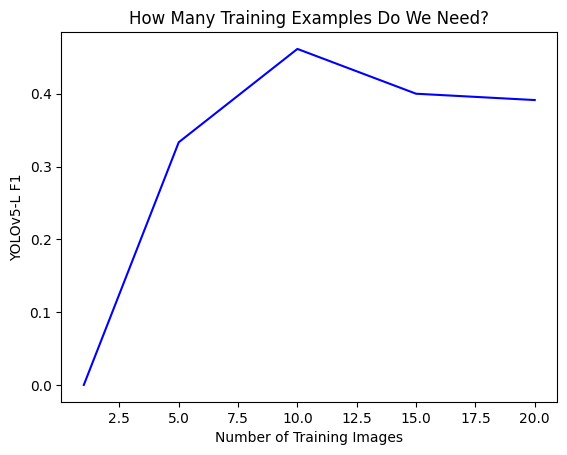

In [54]:
plt.plot(n_train, f1, 'b-')
plt.xlabel("Number of Training Images")
plt.ylabel("YOLOv5-L F1")
plt.title("How Many Training Examples Do We Need?")
plt.savefig("few_shot_f1.png", bbox_inches="tight")
plt.show()

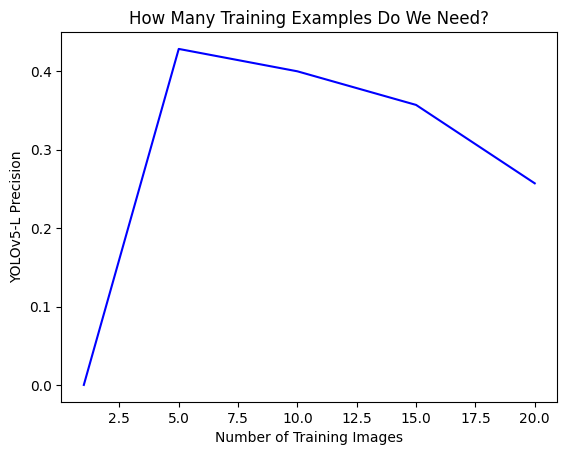

In [55]:
plt.plot(n_train, precision, 'b-')
plt.xlabel("Number of Training Images")
plt.ylabel("YOLOv5-L Precision")
plt.title("How Many Training Examples Do We Need?")
plt.show()

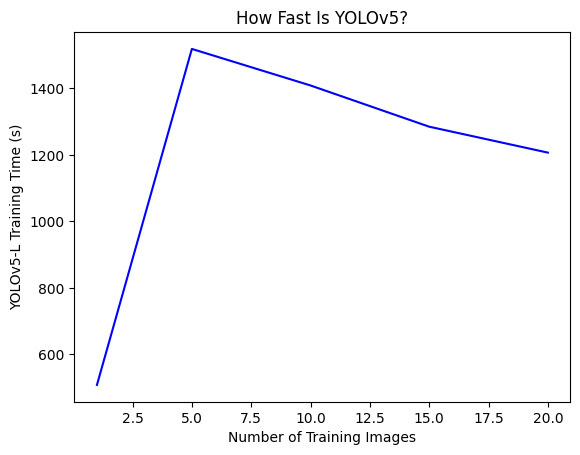

In [59]:
plt.plot(n_train, train_times, 'b-')
plt.xlabel("Number of Training Images")
plt.ylabel("YOLOv5-L Training Time (s)")
plt.title("How Fast Is YOLOv5?")
plt.savefig("few_shot_train.png", bbox_inches="tight")
plt.show()

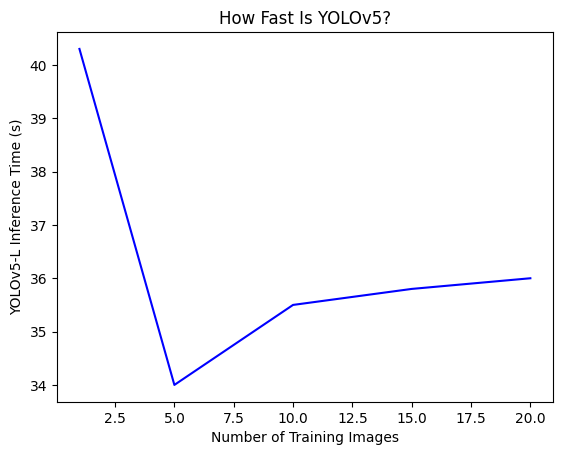

In [60]:
plt.plot(n_train, infer_times, 'b-')
plt.xlabel("Number of Training Images")
plt.ylabel("YOLOv5-L Inference Time (s)")
plt.title("How Fast Is YOLOv5?")
plt.savefig("few_shot_infer.png", bbox_inches="tight")
plt.show()

## Analytics Visualizations
This section is used to develop and adjust various functions that create analytics visualizations from the YOLOv5 model predictions. These functions are used in the backend of the analytics page on the AniML website to render dynamic visualizations based on user-uploaded images.

In [1]:
def parse_yolo_json(yolo_json_path):
    '''
    Function to parse YOLOv5 prediction JSON files.
    Input:
    - yolo_json_path: String. Path to JSON file from YOLOv5 detection run.
    Outputs:
    - image_ids: List of strings. A list of images with detected objects. If an image has multiple objects detected, the image name will be duplicated in the list.
    - pred_classes: List of ints. A list of ints, corresponding to the classes annotated on the images in RoboFlow.
    - bboxes: List of lists. A list of bounding boxes for each detected object. Each sub-list is a list of four floats, denoting coordinates for the corners of the bounding boxes.
    - confs: List of floats. A list of confidence scores for each prediction.
    '''
    import json
    
    # reading in json file
    with open(yolo_json_path, 'r') as pred_json:
        yolo_preds = json.load(pred_json)
    
    # parsing information from json files:
    # image id's (list of strings)
    image_ids = [pred.get("image_id") for pred in yolo_preds]
    # predicted classes (list of ints)
    pred_classes = [pred.get("category_id") for pred in yolo_preds]
    # bounding boxes (list of lists, sublists are lists of floats (normalized coords))
    bboxes = [pred.get("bbox") for pred in yolo_preds]
    # confidence scores (list of floats)
    confs = [pred.get("score") for pred in yolo_preds]

    return image_ids, pred_classes, bboxes, confs

In [2]:
def time_series(pred_df):
    '''
    Function to parse dates and create time-series data from the dates in image names.
    Input:
    - pred_df: pandas DataFrame of YOLOv5 prediction results
    Outputs:
    - 
    '''
    # retrieving date from first four digits of image names in dataframe
    # appended 2022 for convenience but we won't use the year in the time series
    dates = pred_df["Image ID"].apply(lambda x: x[:4]+"2022")
    pred_df["Image Date"] = pd.to_datetime(dates, format="%m%d%Y")
    # adding date as its own column
    pred_df["Image Date"] = pd.to_datetime(dates, format="%m%d%Y")
    
    # grouping by date, imputing missing dates, and flattening dataframe for altair chart
    # this dataframe separates by predicted animal class
    date_df = pred_df.groupby(["Image Date", "Predicted Class"]).size().unstack(fill_value=0).reset_index()
    date_df = date_df.set_index("Image Date").asfreq("D", fill_value=0).reset_index()
    date_df_flat = pd.melt(date_df, id_vars=["Image Date"])
    
    # further aggregating to calculate total animal counts, summing by predicted class
    date_df_total = date_df_flat.drop(["Predicted Class"], axis=1).groupby(["Image Date"]).agg(["sum"])
    date_df_total.columns = date_df_total.columns.get_level_values(0)
    date_df_total.reset_index(inplace=True)
    
    # time-series chart for total detected animals in the dataset
    date_chart_total = alt.Chart(date_df_total).mark_line(point=True, strokeWidth=2).encode(
        x = alt.X("monthdate(Image Date):T", title = "Image Date"),
        y = alt.Y("value:Q", title = "Count of Detected Animals"),
        tooltip = [alt.Tooltip("monthdate(Image Date)", title = "Image Date"),
                   alt.Tooltip("value:Q", title = "Count of Detected Animals")]
    ).configure_point(
        size = 100
    ).properties(
        width = 600,
        height = 300,
        title = "Total Detected Animals Time Series"
    )
    
    # creating concatenated time-series charts for each animal class detected in the dataset
    date_chart_class = alt.Chart(date_df_flat).mark_line(point=True, strokeWidth=2).encode(
        row = alt.Row("Predicted Class:N", title = "Predicted Animal Type"),
        x = alt.X("monthdate(Image Date):T", title = "Image Date"),
        y = alt.Y("value:Q", title = "Count of Detected Animals"),
        color = alt.Color("Predicted Class:N", scale=alt.Scale(scheme="category10"), title="Predicted Animal Type"),
        tooltip = [alt.Tooltip("monthdate(Image Date)", title = "Image Date"),
                   alt.Tooltip("Predicted Class", title = "Animal Type"),
                   alt.Tooltip("value", title = "Count of Detected Animals")]
    ).configure_point(
        size = 100
    ).properties(
        width = 600,
        height = 300,
        title = "Detected Animals Time Series by Animal Type"
    )
    
    return date_chart_total, date_chart_class

In [3]:
import pandas as pd
import altair as alt

In [4]:
# reading in YOLOv5 predictions, parsing json
yolo_json_path = "runs/val/exp8/bestm175_predictions.json"
image_ids, pred_classes, bboxes, confs = parse_yolo_json(yolo_json_path)

# creating pandas dataframe from data for altair chart
pred_df = pd.DataFrame({"Image ID": image_ids, "Predicted Class": pred_classes, "bbox": bboxes, "Confidence": confs})
for i in [0, 1, 2, 3]:
    pred_df[f"bbox{i}"] = pred_df["bbox"].apply(lambda x: x[i])
pred_df = pred_df.drop("bbox", axis=1)
pred_df

,Image ID,Predicted Class,Confidence,bbox0,bbox1,bbox2,bbox3
0,09220107_JPG.rf.1177492fb393be327df414b8180642db,1,0.65947,0.000,371.678,219.097,201.170
1,09220113_JPG.rf.67904d0764563fd6d921e907e034ab23,1,0.35335,499.979,303.098,124.168,142.496
2,09220114_JPG.rf.d3671bfbdda727793746fdfbd12b7371,1,0.59323,487.771,306.535,144.428,154.810
3,09200088_JPG.rf.f087b7a8a23bf745b932d1da2e4b2a93,0,0.32496,72.264,472.586,467.597,130.963
4,09200088_JPG.rf.f087b7a8a23bf745b932d1da2e4b2a93,1,0.31922,105.285,456.369,403.689,155.319
5,09260140_JPG.rf.92ae3de09b0a1e9f9353d7b07c814641,1,0.71568,131.113,352.699,330.549,192.403
6,09260141_JPG.rf.a95ea71af019915331d8918030a7ec9a,1,0.80615,37.301,372.613,306.698,180.813
7,09200086_JPG.rf.c61798dd679adb79a81d75e78b5386ff,1,0.38923,0.000,560.848,54.176,72.252
8,09180079_JPG.rf.b655f8164e6875d1c2479aa844f757e8,1,0.53835,536.240,347.325,99.021,118.565
9,09090019_JPG.rf.b8def9071a90f5525f050cb0e0d892f9,1,0.81757,451.787,313.413,187.715,145.420


In [5]:
class_chart = alt.Chart(pred_df).mark_bar().encode(
    x = alt.X("Predicted Class:N", title="Predicted Class"),
    y = alt.Y("count():Q", title="Count"),
    color = alt.Color("Predicted Class:N", scale=alt.Scale(scheme="category10")),
    tooltip = ["Predicted Class", "count()"]
).properties(
    width = 200,
    height = 300,
    title = "Counts of Predicted Classes"
)
class_chart

alt.Chart(...)

In [6]:
conf_chart = alt.Chart(pred_df).mark_bar().encode(
    x = alt.X("Confidence:Q", bin=alt.Bin(maxbins=10), title="Predicted Class"),
    y = alt.Y("count():Q", title="Count"),
    color = alt.Color("Predicted Class:N", scale=alt.Scale(scheme="category10")),
    tooltip = [alt.X("Confidence:Q", bin=alt.Bin(maxbins=10), title="Confidence Interval"), "Predicted Class", "count()"]
).properties(
    width = 200,
    height = 300,
    title = "Histogram of Confidence Levels"
)
conf_chart

alt.Chart(...)

In [7]:
class_chart | conf_chart

alt.HConcatChart(...)

In [8]:
# retrieving date from first four digits of image names in dataframe
# appended 2022 for convenience but we won't use the year in the time series
dates = pred_df["Image ID"].apply(lambda x: x[:4]+"2022")
# dates

In [9]:
# adding date as its own column
pred_df["Image Date"] = pd.to_datetime(dates, format="%m%d%Y")
pred_df

,Image ID,Predicted Class,Confidence,bbox0,bbox1,bbox2,bbox3,Image Date
0,09220107_JPG.rf.1177492fb393be327df414b8180642db,1,0.65947,0.000,371.678,219.097,201.170,2022-09-22
1,09220113_JPG.rf.67904d0764563fd6d921e907e034ab23,1,0.35335,499.979,303.098,124.168,142.496,2022-09-22
2,09220114_JPG.rf.d3671bfbdda727793746fdfbd12b7371,1,0.59323,487.771,306.535,144.428,154.810,2022-09-22
3,09200088_JPG.rf.f087b7a8a23bf745b932d1da2e4b2a93,0,0.32496,72.264,472.586,467.597,130.963,2022-09-20
4,09200088_JPG.rf.f087b7a8a23bf745b932d1da2e4b2a93,1,0.31922,105.285,456.369,403.689,155.319,2022-09-20
5,09260140_JPG.rf.92ae3de09b0a1e9f9353d7b07c814641,1,0.71568,131.113,352.699,330.549,192.403,2022-09-26
6,09260141_JPG.rf.a95ea71af019915331d8918030a7ec9a,1,0.80615,37.301,372.613,306.698,180.813,2022-09-26
7,09200086_JPG.rf.c61798dd679adb79a81d75e78b5386ff,1,0.38923,0.000,560.848,54.176,72.252,2022-09-20
8,09180079_JPG.rf.b655f8164e6875d1c2479aa844f757e8,1,0.53835,536.240,347.325,99.021,118.565,2022-09-18
9,09090019_JPG.rf.b8def9071a90f5525f050cb0e0d892f9,1,0.81757,451.787,313.413,187.715,145.420,2022-09-09


In [10]:
# grouping by date, imputing missing dates, and flattening dataframe for altair chart
# this dataframe separates by predicted animal class
date_df = pred_df.groupby(["Image Date", "Predicted Class"]).size().unstack(fill_value=0).reset_index()
date_df = date_df.set_index("Image Date").asfreq("D", fill_value=0).reset_index()
date_df_flat = pd.melt(date_df, id_vars=["Image Date"])
# date_df_flat

In [11]:
# further aggregating to calculate total animal counts, summing by predicted class
date_df_total = date_df_flat.drop(["Predicted Class"], axis=1).groupby(["Image Date"]).agg(["sum"])
date_df_total.columns = date_df_total.columns.get_level_values(0)
date_df_total.reset_index(inplace=True)
# date_df_total

In [12]:
# time-series chart for total detected animals in the dataset
date_chart_total = alt.Chart(date_df_total).mark_line(point=True, strokeWidth=2).encode(
    x = alt.X("monthdate(Image Date):T", title = "Image Date"),
    y = alt.Y("value:Q", title = "Count of Detected Animals"),
    tooltip = [alt.Tooltip("monthdate(Image Date)", title = "Image Date"),
               alt.Tooltip("value:Q", title = "Count of Detected Animals")]
).configure_point(
    size = 100
).properties(
    width = 600,
    height = 300,
    title = "Total Detected Animals Time Series"
)
date_chart_total

alt.Chart(...)

In [13]:
title = alt.TitleParams('A centered title', anchor='middle')
# creating separate time-series charts for each animal class detected in the dataset
date_chart_class = alt.Chart(date_df_flat, title=title).mark_line(point=True, strokeWidth=2).encode(
    row = alt.Row("Predicted Class:N", title = "Predicted Animal Class"),
    x = alt.X("monthdate(Image Date):T", title = "Image Date"),
    y = alt.Y("value:Q", title = "Count of Detected Animals"),
    color = alt.Color("Predicted Class:N", scale=alt.Scale(scheme="category10")),
    tooltip = [alt.Tooltip("monthdate(Image Date)", title = "Image Date"),
               alt.Tooltip("Predicted Class", title = "Predicted Class"),
               alt.Tooltip("value", title = "Count of Detected Animals")]
).configure_point(
    size = 100
).properties(
    width = 600,
    height = 300,
    # title = "Detected Animals Time Series"
)
date_chart_class

alt.Chart(...)

In [14]:
# making sure the function works
time_series_total, time_series_class = time_series(pred_df)

In [15]:
time_series_total

alt.Chart(...)

In [16]:
time_series_class

alt.Chart(...)

In [17]:
time_series_class.configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_header(
    labelFontSize=20,
    titleFontSize=20
).configure_title(
    fontSize=20,
    align="right"
).configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    labelFontSize=20,
    titleFontSize=15,
)

alt.Chart(...)